<center><h1>ToMakeUp</h1></center>
<center><h4>Predicción del estado de la viscosidad (Fase 1)</h4></center>

### Objetivo

El objetivo del notebook es realizar un estudio de los datos y la creación de un modelo de predicción del estado de la viscosidad de los tintes con los datos que tenemos disponibles previos al inicio de la producción del tinte.

### Importación de las librerías

In [63]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    roc_curve,
)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedGroupKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler

Creamos una constante donde pondremos el random state para que los resultados sean reproducibles.

In [121]:
RANDOM_SEED = 12

### Descripción de los datos

In [3]:
# Cargamos el dataset
ordenes_df = pd.read_csv("clean_data/ordenes.csv")

In [4]:
ordenes_df.head()

,codigo_tinte,cantidad,reactor,fecha,grado_llenado,target,agua,colorante,emulsionante,excipiente
0,621005,904.8,mediano,2021-12-01 10:10:01.010000,0.90,1,501.54,60.50,230,207.96
1,628065,452.4,pequeño,2021-12-01 11:18:00.663000,0.90,0,613.19,10.95,200,175.86
2,628175,2726.0,grande,2021-12-13 15:57:36.703000,0.91,0,613.26,11.88,200,174.86
3,629915,2262.0,grande,2021-12-02 10:56:21.883000,0.75,1,528.23,4.82,180,286.95
4,629925,452.4,mediano,2021-12-02 11:44:03.573000,0.45,0,535.08,0.97,180,283.95


Descripción de los datos:

| Column Name  | Description |
|--------------|-------------|
| `codigo_tinte` | Código numérico del tinte a fabricar |
| `cantidad`     | Cantidad total de tinte producido |
| `reactor`    | Reactor donde se produce el tinte, tenemos 3 reactores  [Grande, Mediano, Pequeño] |
| `fecha`        | Fecha de la medición de la viscosidad |
| `grado_llenado`| Tanto por ciento de llenado del reactor donde se produce el tinte |
| `target`       | Indica si la medición de la viscosidad ha sido correcta o no, 1 viscosidad no válida, 0 viscosidad válida |
| `agua`         | Proporción de agua en Kg para 1000 Kg de producción de tinte |
| `colorante`    | Proporción de colorante en Kg para 1000 Kg de producción de tinte |
| `emulsionante` | Proporción de emulsionante en Kg para 1000 Kg de producción de tinte |
| `excipiente`   | Proporción de excipiente en Kg para 1000 Kg de producción de tinte |


### Análisis exploratorio de los datos

In [5]:
ordenes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   codigo_tinte   490 non-null    int64  
 1   cantidad       490 non-null    float64
 2   reactor        490 non-null    object 
 3   fecha          490 non-null    object 
 4   grado_llenado  490 non-null    float64
 5   target         490 non-null    int64  
 6   agua           490 non-null    float64
 7   colorante      490 non-null    float64
 8   emulsionante   490 non-null    int64  
 9   excipiente     490 non-null    float64
dtypes: float64(5), int64(3), object(2)
memory usage: 38.4+ KB


In [6]:
ordenes_df.describe()

,codigo_tinte,cantidad,grado_llenado,target,agua,colorante,emulsionante,excipiente
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000
mean,626401.367347,791.174755,0.620367,0.328571,584.459184,17.337020,208.244898,190.082694
std,2979.201089,658.916231,0.195702,0.470174,50.212871,13.773473,28.375967,34.068776
min,620025.000000,232.000000,0.230000,0.000000,466.240000,0.000000,160.000000,125.860000
25%,625187.500000,232.000000,0.460000,0.000000,540.050000,6.275000,190.000000,175.360000
50%,627135.000000,452.400000,0.530000,0.000000,592.240000,13.780000,200.000000,178.860000
75%,628445.000000,904.800000,0.900000,1.000000,618.340000,27.900000,230.000000,194.860000
max,629995.000000,2726.000000,0.910000,1.000000,682.340000,60.500000,270.000000,289.950000


#### Distribución de la variable target

Text(0.5, 1.0, "Distribución de la variable 'target'")

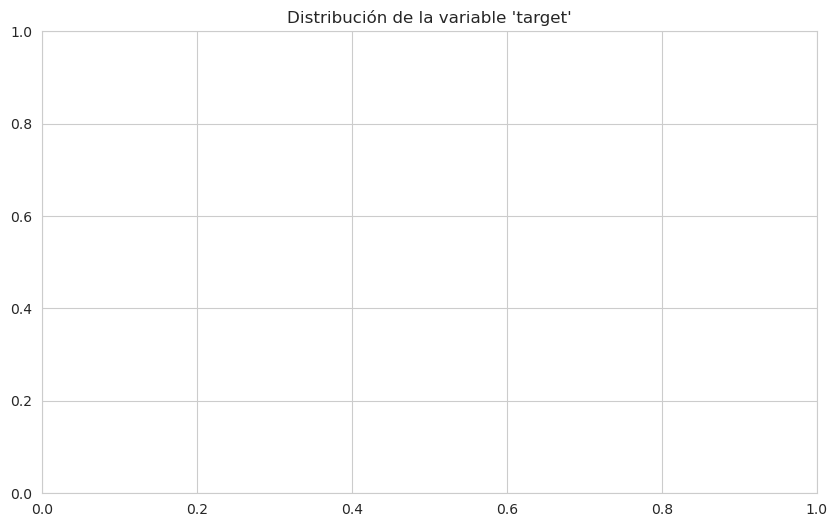

In [7]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
plt.title("Distribución de la variable 'target'")



#### Distribución de las variables numéricas

Distribución de la variable objetivo (Estado de la viscosidad)

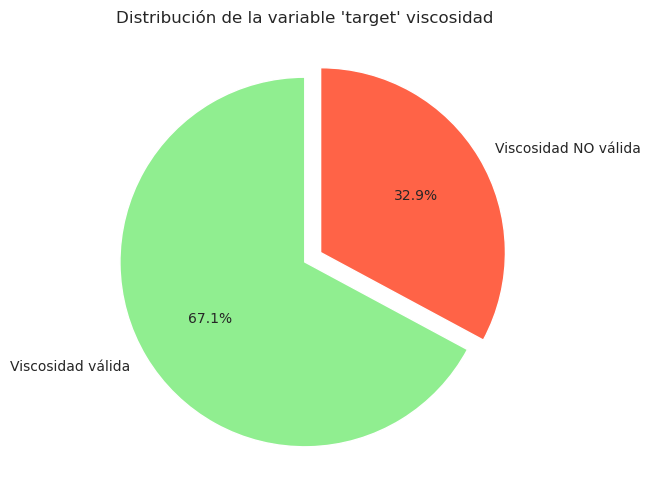

In [8]:
plt.figure(figsize=(10, 6))
plt.title("Distribución de la variable 'target' viscosidad")
colors = ["lightgreen", "tomato"]
exlplode = (0, 0.1)
sns.set_palette("pastel")
plt.pie(
    ordenes_df["target"].value_counts(),
    labels=["Viscosidad válida", "Viscosidad NO válida"],
    colors=colors,
    autopct="%1.1f%%",
    startangle=90,
    explode=exlplode,
)
plt.show()

Distribución de las características numéricas

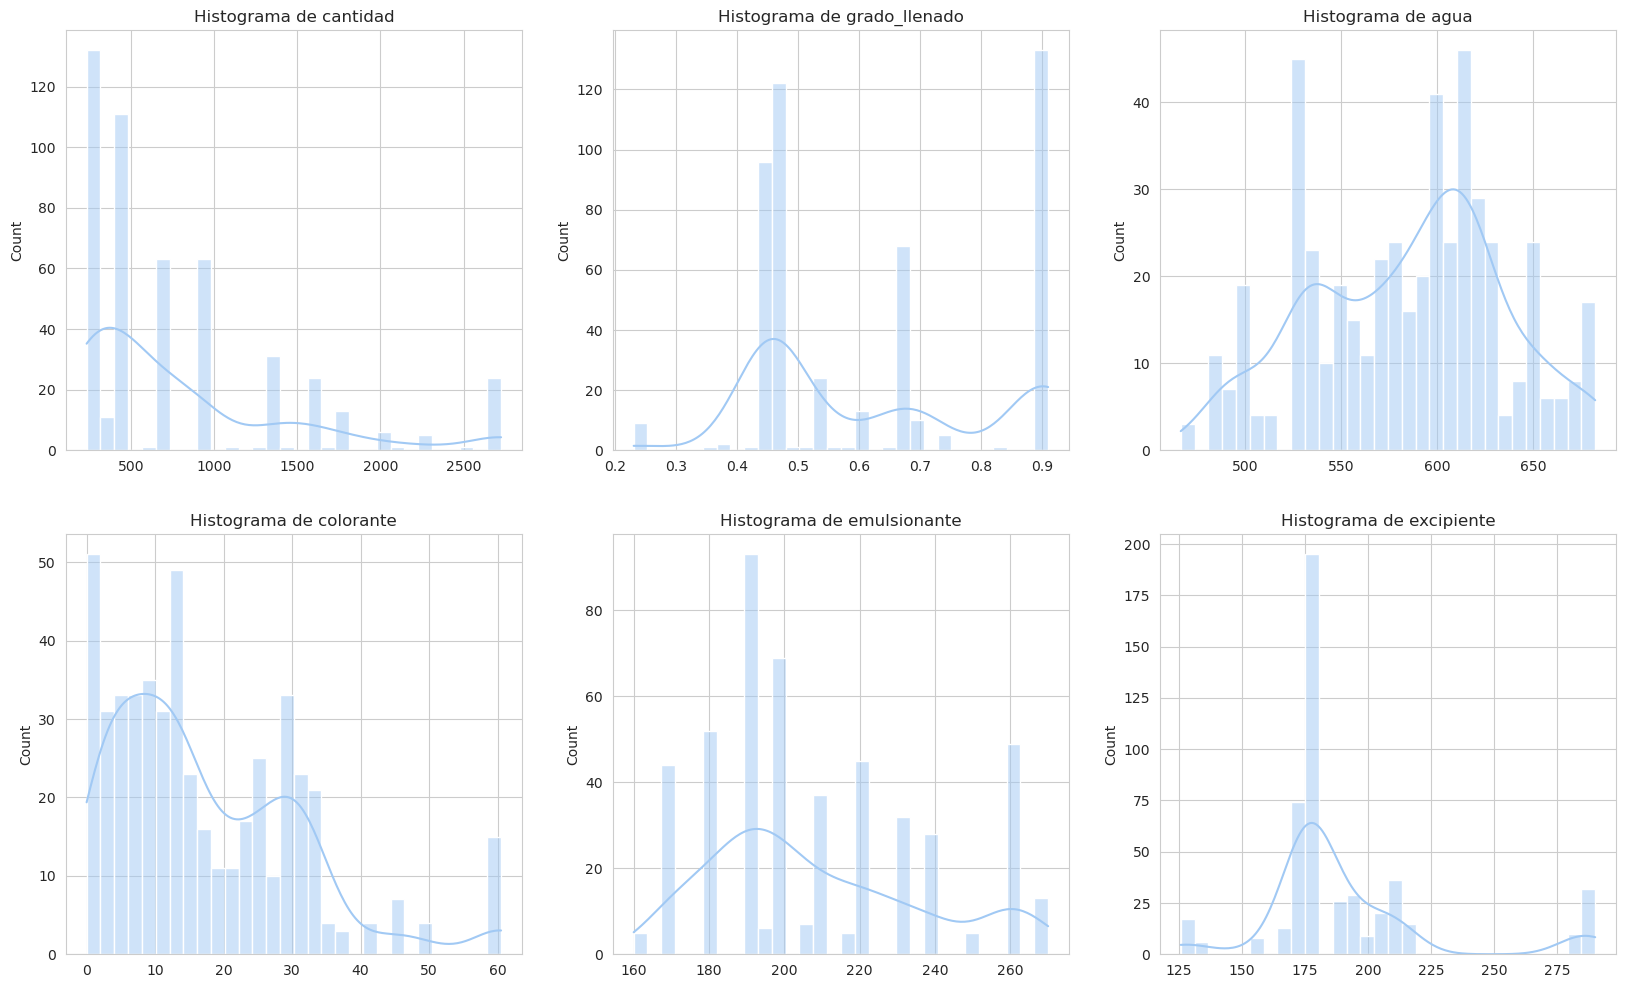

In [9]:
num_columns = ["cantidad", "grado_llenado", "agua", "colorante", "emulsionante", "excipiente"]

fig, ax = plt.subplots(2, 3, figsize=(20, 12))

sns.set_style("darkgrid")
for i, col in enumerate(num_columns, 1):
    plt.subplot(2, 3, i)    
    sns.histplot(ordenes_df[col], bins=30, kde=True)
    plt.title(f'Histograma de {col}')
    plt.xlabel("")    

plt.show()

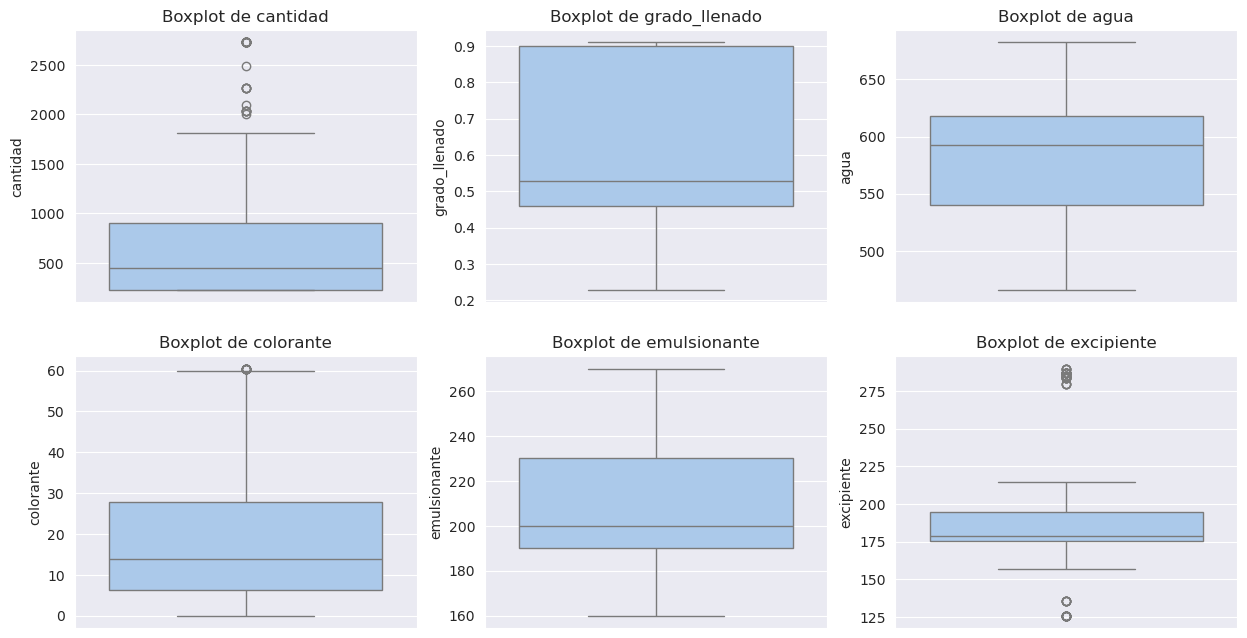

In [10]:
# Create boxplots for numerical columns
plt.figure(figsize=(15, 12))
sns.set_style("darkgrid")
for i, col in enumerate(num_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=ordenes_df[col])                
    plt.title(f'Boxplot de {col}')

plt.show()

#### Distribución de las variables categóricas

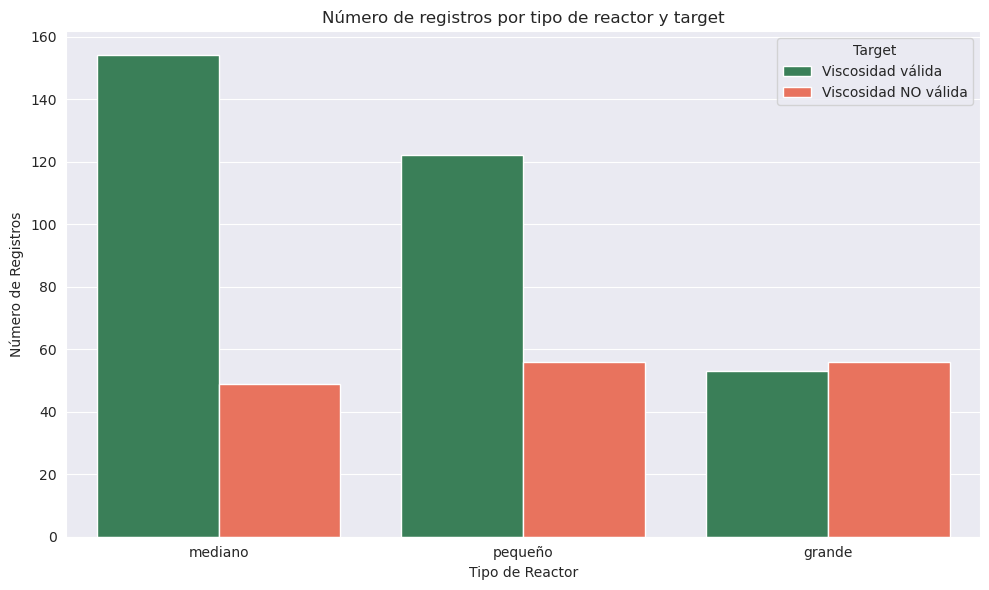

In [11]:
# Definir una paleta personalizada con verde para target 0 y rojo para target 1
custom_palette = {0: "seagreen", 1: "tomato"}
sns.set_style("darkgrid")

# Dibujar la gráfica de barras con la paleta personalizada
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='reactor', hue='target', data=ordenes_df, palette=custom_palette)

# Etiquetas y título
plt.title('Número de registros por tipo de reactor y target')
plt.xlabel('Tipo de Reactor')
plt.ylabel('Número de Registros')
plt.legend(title='Target', loc='upper right', labels=['Viscosidad válida', 'Viscosidad NO válida'])

plt.tight_layout()
plt.show()

Hay mayor reprocesamiento en el reactor grande

Vamos a ver la distribución por código de tinte

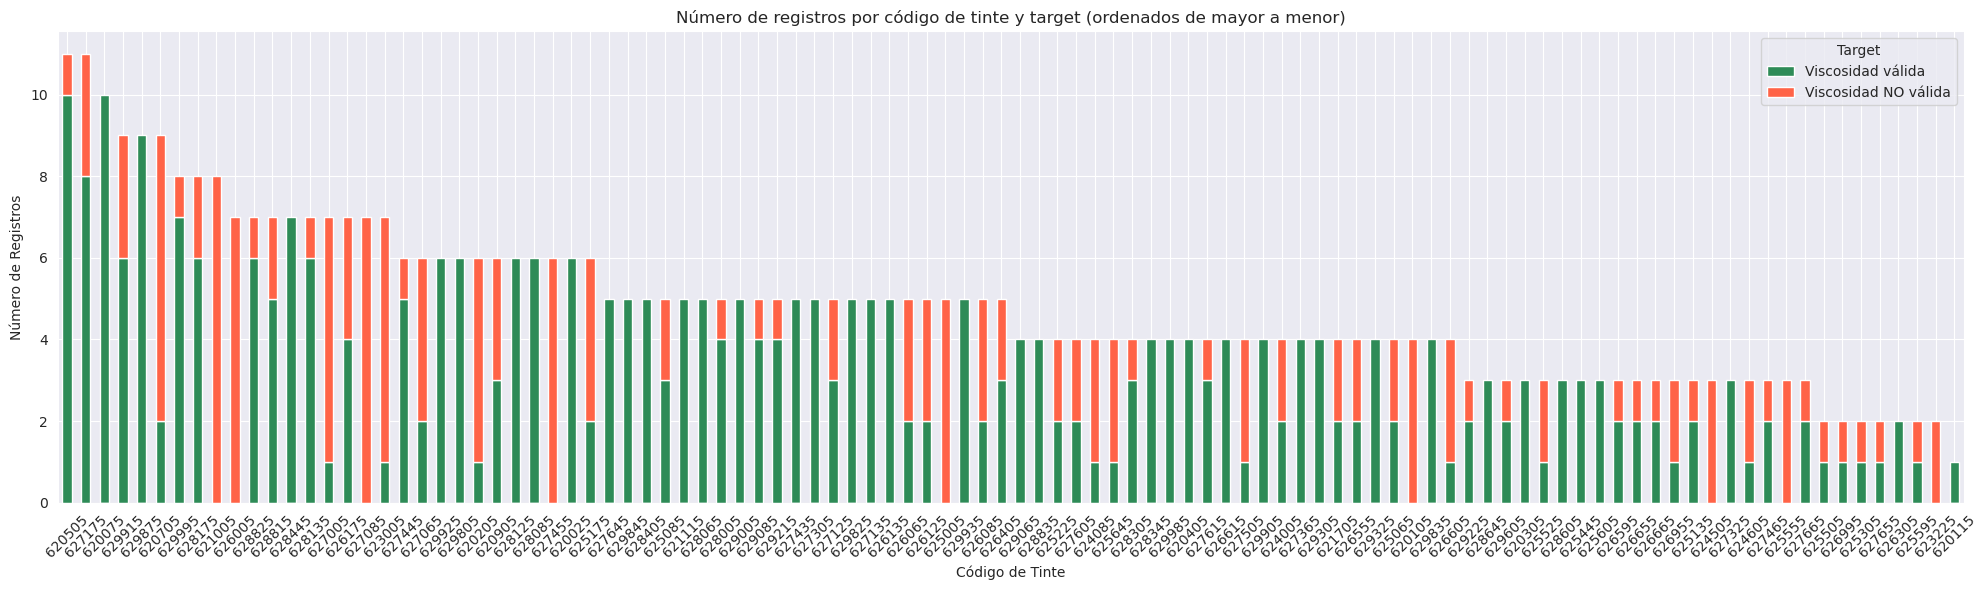

In [12]:
# Agrupar por 'codigo_tinte' y 'target' y contar registros
grouped_data = ordenes_df.groupby(['codigo_tinte', 'target']).size().unstack().fillna(0)

sns.set_style("darkgrid")

# Ordenar los datos por el total de registros (de mayor a menor)
sorted_data = grouped_data.sum(axis=1).sort_values(ascending=False)
grouped_sorted_data = grouped_data.loc[sorted_data.index]

# Crear un gráfico de barras apiladas con los datos ordenados
ax = grouped_sorted_data.plot(kind='bar', stacked=True, figsize=(20, 6), color=[custom_palette[0], custom_palette[1]])

# Etiquetas y título
plt.title('Número de registros por código de tinte y target (ordenados de mayor a menor)')
plt.xlabel('Código de Tinte')
plt.ylabel('Número de Registros')
plt.legend(title='Target', loc='upper right', labels=['Viscosidad válida', 'Viscosidad NO válida'])
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [13]:
# Filtrar los códigos de tinte que solo tienen registros con target = 1
tintes_target_1 = grouped_data[grouped_data[0] == 0].index

print (f"Los tintes que fallan siempre en la primera medición de viscosidad son: {tintes_target_1.values}")

Los tintes que fallan siempre en la primera medición de viscosidad son: [620105 621005 623225 624505 625005 625555 626005 627085 627455]


Pairplot de todas las variables

/home/nicolas/anaconda3/envs/kaggle_3_11/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


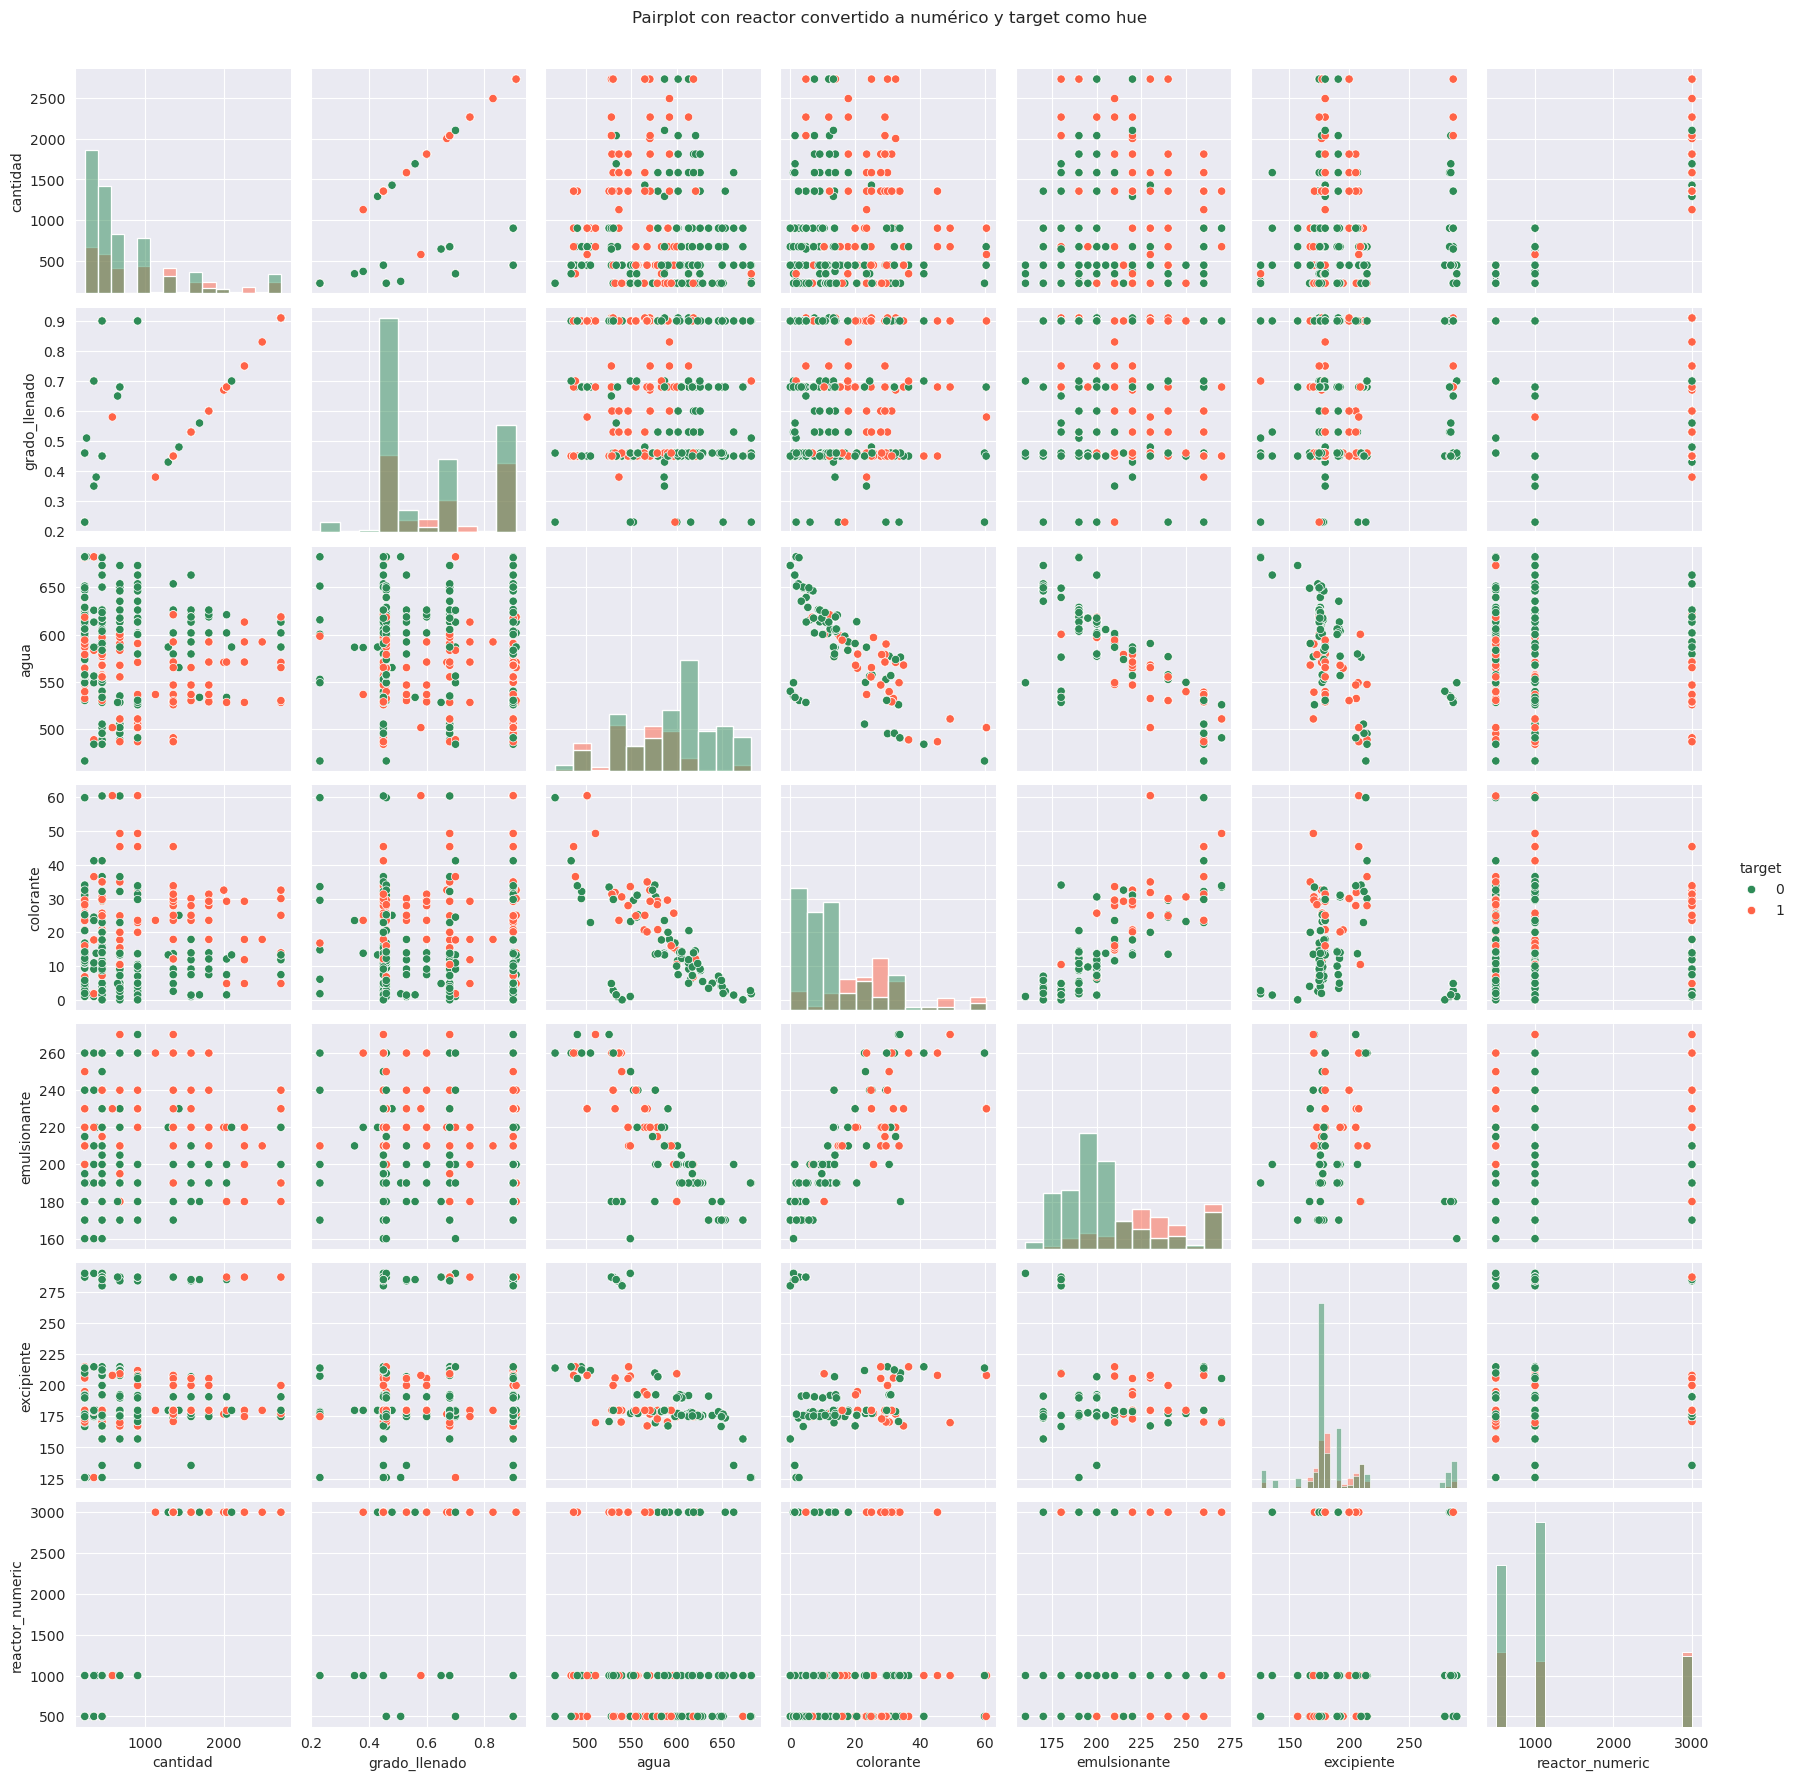

In [14]:
# Convertir la columna 'reactor' a numérica según las equivalencias dadas
ordenes_df['reactor_numeric'] = ordenes_df['reactor'].map({'pequeño': 500, 'mediano': 1000, 'grande': 3000})
sns.set_style("darkgrid")
# Crear un pairplot con 'reactor_numeric' y 'target' como hue
sns.pairplot(ordenes_df.drop(columns=['codigo_tinte', 'reactor']), hue="target", palette=custom_palette, diag_kind="hist")
plt.suptitle('Pairplot con reactor convertido a numérico y target como hue', y=1.02)
plt.show()

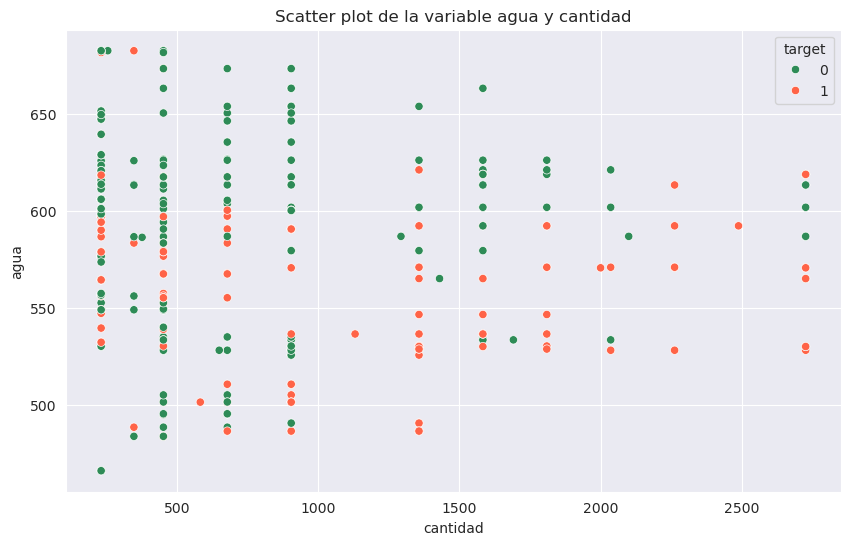

In [15]:
# Scatter plot de la variable agua y cantidad
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10, 6))
sns.scatterplot(x='cantidad', y='agua', hue='target', data=ordenes_df, palette=custom_palette)

plt.title('Scatter plot de la variable agua y cantidad')
plt.show()

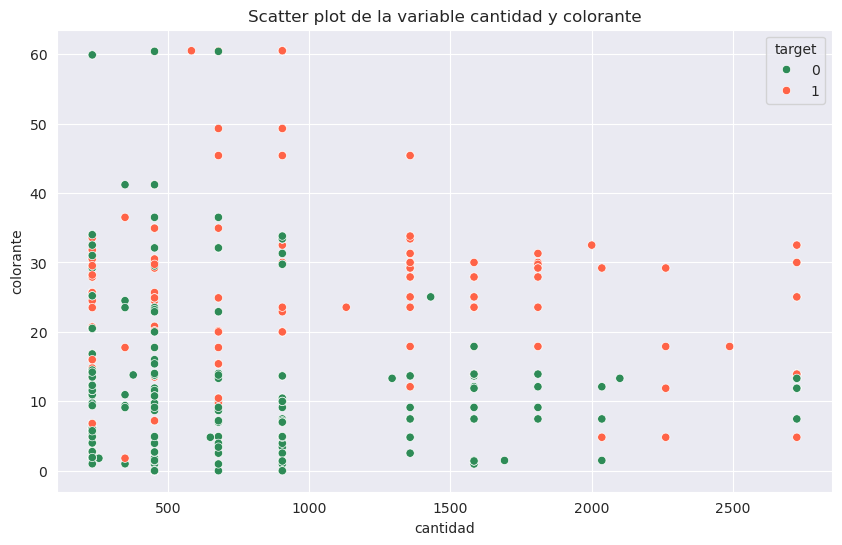

In [16]:
# Scatter plot de la variable colorante y cantidad
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10, 6))
sns.scatterplot(x='cantidad', y='colorante', hue='target', data=ordenes_df, palette=custom_palette)

plt.title('Scatter plot de la variable cantidad y colorante')
plt.show()

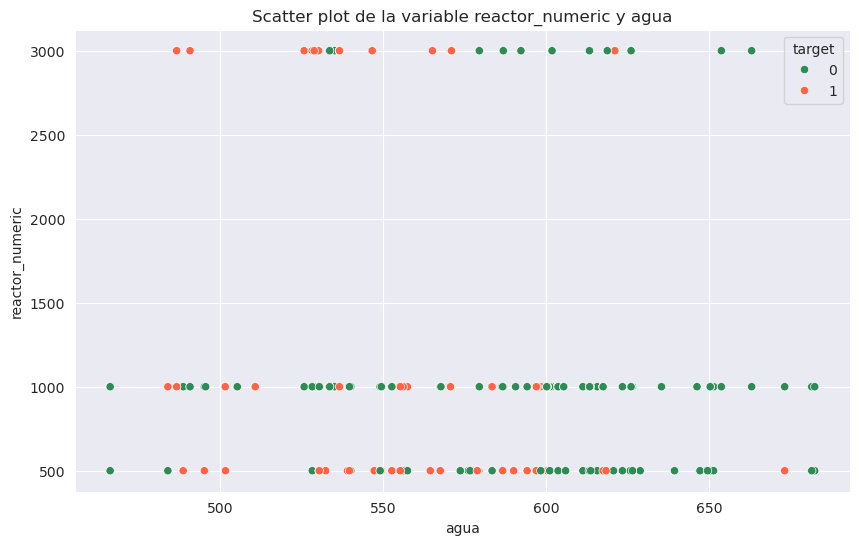

In [17]:
# Scatter plot de la variable agua y reactor_numeric
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10, 6))
sns.scatterplot(x='agua', y='reactor_numeric', hue='target', data=ordenes_df, palette=custom_palette)

plt.title('Scatter plot de la variable reactor_numeric y agua')
plt.show()

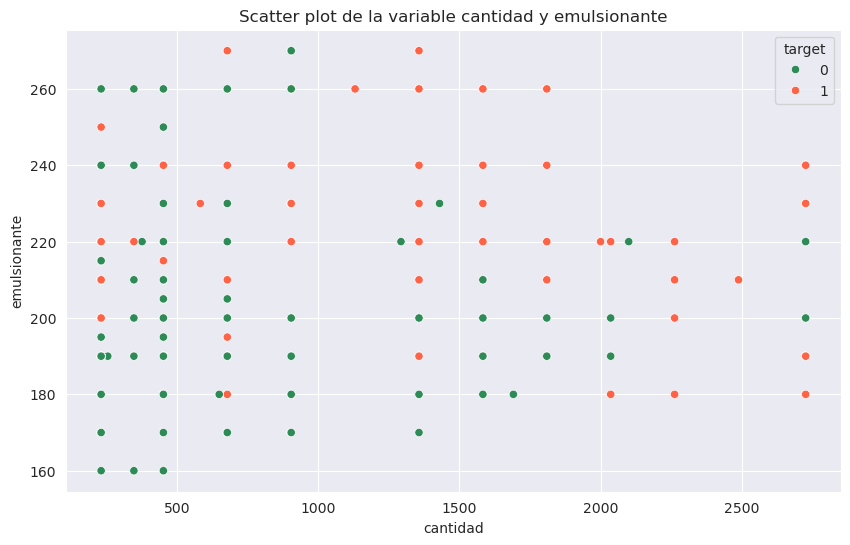

In [18]:
# Scatter plot de la variable cantidad y emulsionante
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10, 6))
sns.scatterplot(x='cantidad', y='emulsionante', hue='target', data=ordenes_df, palette=custom_palette)

plt.title('Scatter plot de la variable cantidad y emulsionante')
plt.show()

Dibujamos la serie temporal de la evolución de la viscosidad

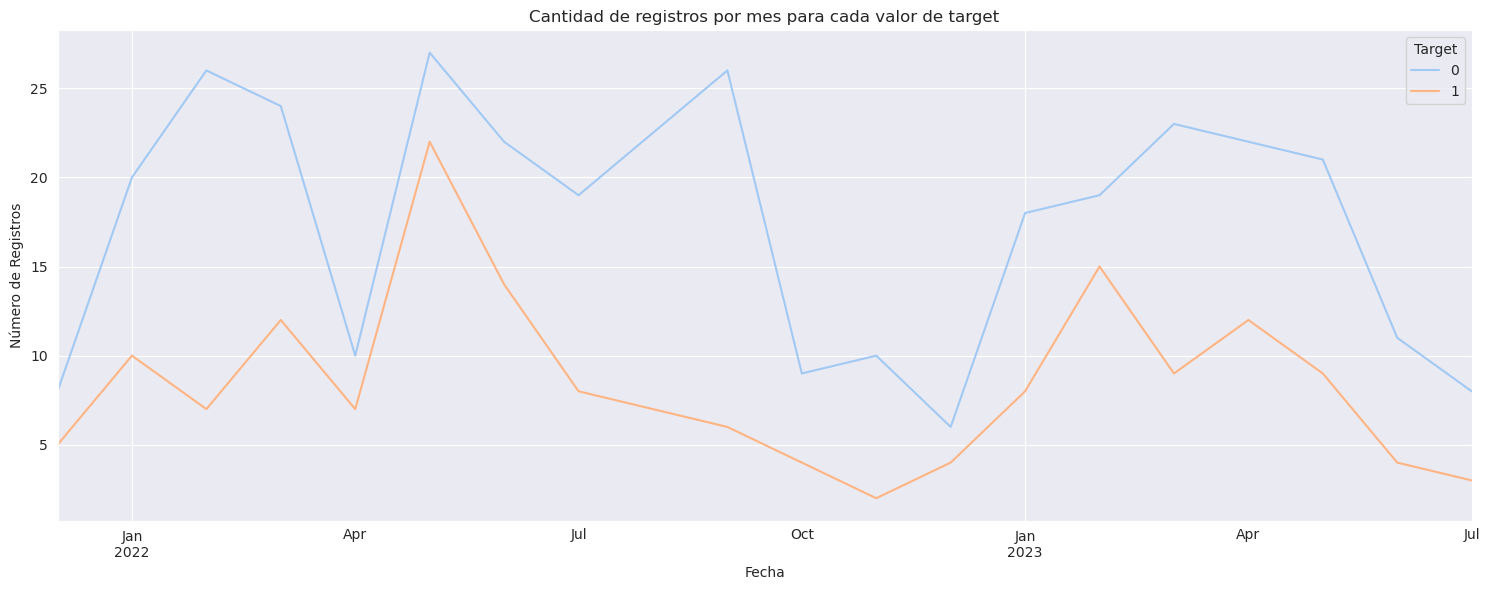

In [19]:
# Convertir la columna 'fecha' a datetime
ordenes_df['fecha'] = pd.to_datetime(ordenes_df['fecha'],format="mixed")

# Agrupar por mes y target y contar registros
grouped_time = ordenes_df.groupby([ordenes_df['fecha'].dt.to_period("M"), 'target']).size().unstack().fillna(0)

# Crear una gráfica de líneas para mostrar la cantidad de registros por mes para cada valor de target
plt.figure(figsize=(15, 6))
grouped_time.plot(ax=plt.gca())

# Etiquetas y título
plt.title('Cantidad de registros por mes para cada valor de target')
plt.xlabel('Fecha')
plt.ylabel('Número de Registros')
plt.legend(title='Target')

plt.tight_layout()
plt.show()

#### Matriz de correlación

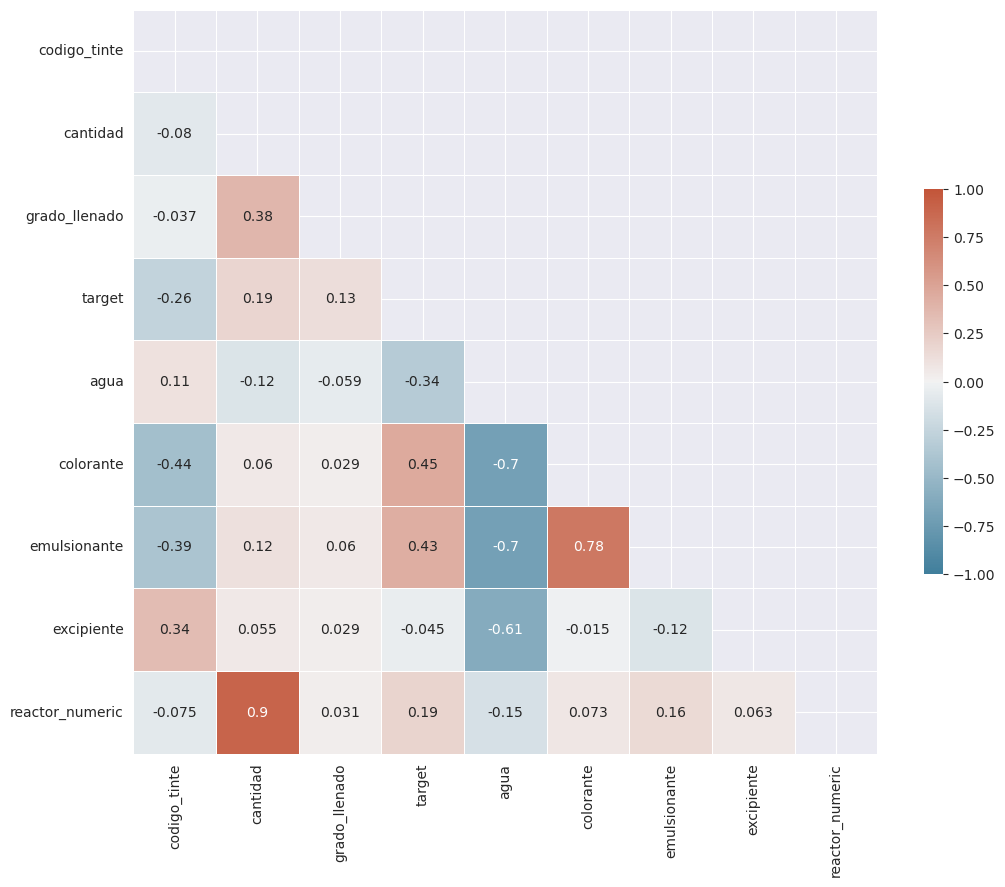

In [20]:
corr = ordenes_df.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio, show annotations
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
);

### Data preprocessing

Elliminamos las columnas de `codigo_tinte` y `fecha` ya que no aportan información al modelo.

Tambien eliminamos la columna de `reactor_numeric` ya que es una variable que hemos creado para el análisis exploratorio de los datos.

In [21]:
ordenes_df_clean = ordenes_df.drop(columns=['codigo_tinte', 'reactor_numeric', 'fecha'], inplace=False)

In [22]:
ordenes_df_clean.head()

,cantidad,reactor,grado_llenado,target,agua,colorante,emulsionante,excipiente
0,904.8,mediano,0.90,1,501.54,60.50,230,207.96
1,452.4,pequeño,0.90,0,613.19,10.95,200,175.86
2,2726.0,grande,0.91,0,613.26,11.88,200,174.86
3,2262.0,grande,0.75,1,528.23,4.82,180,286.95
4,452.4,mediano,0.45,0,535.08,0.97,180,283.95


Onehot encoding de las variable reactor

In [23]:
ordenes_df_enconded = pd.get_dummies(ordenes_df_clean, columns=['reactor'], drop_first=True)

In [24]:
ordenes_df_enconded.head()

,cantidad,grado_llenado,target,agua,colorante,emulsionante,excipiente,reactor_mediano,reactor_pequeño
0,904.8,0.90,1,501.54,60.50,230,207.96,True,False
1,452.4,0.90,0,613.19,10.95,200,175.86,False,True
2,2726.0,0.91,0,613.26,11.88,200,174.86,False,False
3,2262.0,0.75,1,528.23,4.82,180,286.95,False,False
4,452.4,0.45,0,535.08,0.97,180,283.95,True,False


Creamos un set para las características y otro para la variable objetivo

In [122]:
X = ordenes_df_enconded.drop(columns=["target"], inplace=False)
y = ordenes_df_enconded["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y
)

print(f"Dimensiones del dataset de entrenamiento: {X_train.shape}")
print(f"Dimensiones del dataset de prueba: {X_test.shape}")

Dimensiones del dataset de entrenamiento: (343, 8)
Dimensiones del dataset de prueba: (147, 8)


In [114]:
X_train.head()

,cantidad,grado_llenado,agua,colorante,emulsionante,excipiente,reactor_mediano,reactor_pequeño
344,904.8,0.90,600.15,9.99,200,189.86,True,False
44,904.8,0.90,533.57,1.48,180,284.95,True,False
364,232.0,0.46,649.14,4.00,180,166.86,False,True
487,1583.4,0.53,565.10,25.04,230,179.86,False,False
445,678.6,0.68,635.34,3.40,170,191.26,True,False


Escalamos los datos, utilizo MinMaxScaler ya que podemos considerar que no hay excesivos outliers en los datos.

In [123]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,cantidad,grado_llenado,agua,colorante,emulsionante,excipiente,reactor_mediano,reactor_pequeño
0,0.541860,0.441176,0.371957,0.461322,0.545455,0.485100,0.0,0.0
1,0.000000,0.338235,0.418325,0.512397,0.545455,0.405265,0.0,1.0
2,0.088372,0.323529,0.180472,0.378512,0.909091,0.524103,1.0,0.0
3,0.813953,0.764706,0.484498,0.482645,0.545455,0.329088,0.0,0.0
4,1.000000,1.000000,0.680333,0.196364,0.363636,0.298617,0.0,0.0


### Modelización

#### Funciones auxiliares

In [28]:
def perform_search(gs, X_train, y_train):
    """
    Performs a grid search using the provided GridSearchCV o RandomizedSearchCV object on the provided training data.
    
    Parameters:
    gs (GridSearchCV o RandomizedSearchCV): The search object.
    X_train (array-like): The feature matrix for the training data.
    y_train (array-like): The labels for the training data.
    
    Returns:
    The best estimator found during the grid search.
    """
    warnings.filterwarnings('ignore')

    # Fit the GridSearchCV object to the training data
    gs.fit(X_train, y_train)
    
    # Print the best hyperparameters found during the grid search
    print("Best parameters:", gs.best_params_)
    
    # Print the highest mean cross-validated score achieved by the best estimator
    print("Best score:", gs.best_score_)
    
    # Print the best estimator
    print("Best estimator:", gs.best_estimator_)
    
    warnings.resetwarnings()

    # Return the best estimator
    return gs.best_estimator_

In [29]:
def clf_report(model, X_test, y_test):
    """
    Generates a classification report for the provided model on the provided test data.
    
    Parameters:
    model (sklearn estimator): The model to generate the classification report for.
    X_test (array-like): The feature matrix for the test data.
    y_test (array-like): The labels for the test data.
    """
    # Generate predictions for the test data
    y_pred = model.predict(X_test)
    
    # Print the accuracy score of the model
    print("Accuracy score:", accuracy_score(y_test, y_pred), end="\n\n")

    # Print the classification report
    print(classification_report(y_test, y_pred))
    
    # Print the confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')

    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label');

In [30]:
def plot_ROC_AUC_curves(model, X_train, y_train, X_test, y_test, model_name):
    """
    Plots the ROC (Receiver Operating Characteristic) curves and AUC (Area Under the Curve)
    scores for the given model, using both training and testing data.
    
    Parameters:
    model (object): The classifier model to evaluate.
    X_train (array-like): The feature matrix for the training data.
    y_train (array-like): The labels for the training data.
    X_test (array-like): The feature matrix for the testing data.
    y_test (array-like): The labels for the testing data.
    model_name (str): A name for the model, used in the plot title.
    
    Returns:
    None. Displays the plot using plt.show().
    """
    # Get the probabilities of the positive class for training and testing data
    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve for training data
    fpr_train, tpr_train, _ = roc_curve(y_train, train_probs)
    roc_auc_train = auc(fpr_train, tpr_train)
    
    # Calculate the ROC curve for test data
    fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Set up the figure and axis for the plot, with a specified size
    plt.figure(figsize=(10, 7))
    
    # Plot the ROC curve for the training data
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
    
    # Plot the ROC curve for the testing data
    plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
    
    # Plot a gray dashed line representing random guessing
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    
    # Set the limits of the x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    # Label the axes and the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}')
    
    # Add a legend to the plot
    plt.legend(loc='lower right')
    
    # Add a grid to the plot
    plt.grid(True)
    
    # Display the plot
    plt.show()

#### Naive Bayes

In [59]:
gnb = GaussianNB()

gnb.fit(X_train_scaled, y_train)

GaussianNB()

Accuracy score: 0.7482993197278912

              precision    recall  f1-score   support

           0       0.82      0.81      0.81        99
           1       0.61      0.62      0.62        48

    accuracy                           0.75       147
   macro avg       0.71      0.72      0.72       147
weighted avg       0.75      0.75      0.75       147



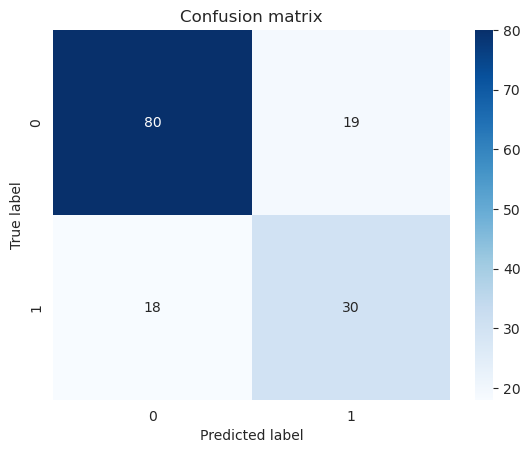

In [60]:
clf_report(gnb, X_test_scaled, y_test)

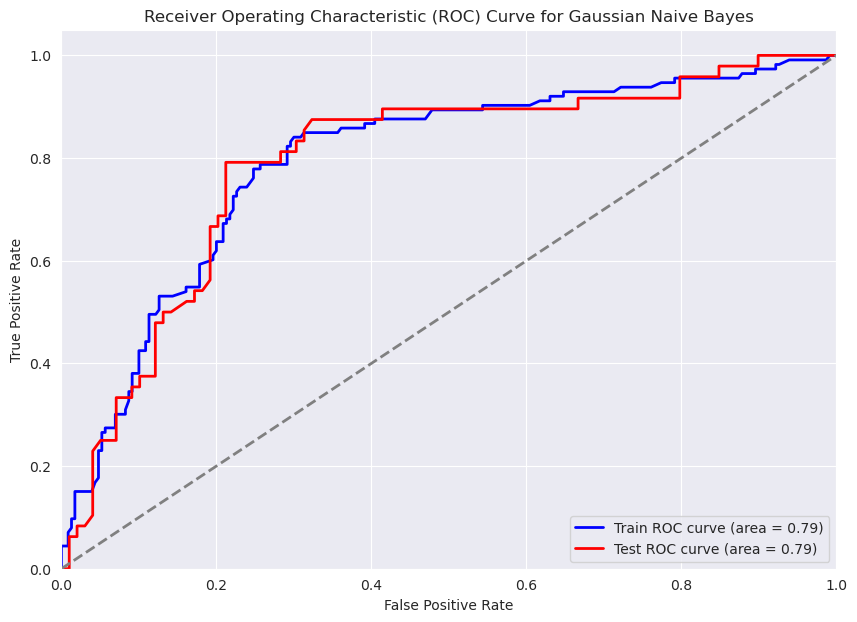

In [62]:
plot_ROC_AUC_curves(gnb, X_train_scaled, y_train, X_test_scaled, y_test, "Gaussian Naive Bayes")

#### Random Forest

Accuracy score: 0.8299319727891157

              precision    recall  f1-score   support

           0       0.87      0.88      0.87        99
           1       0.74      0.73      0.74        48

    accuracy                           0.83       147
   macro avg       0.81      0.80      0.81       147
weighted avg       0.83      0.83      0.83       147



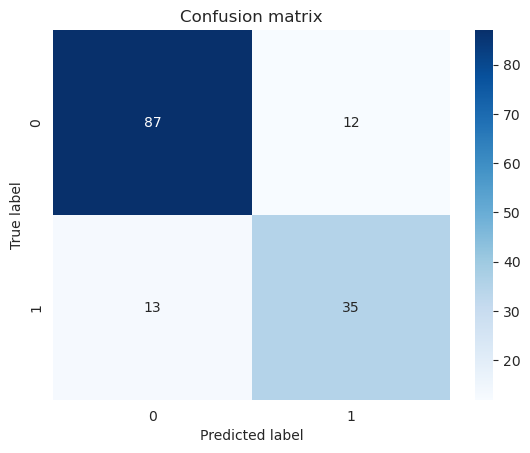

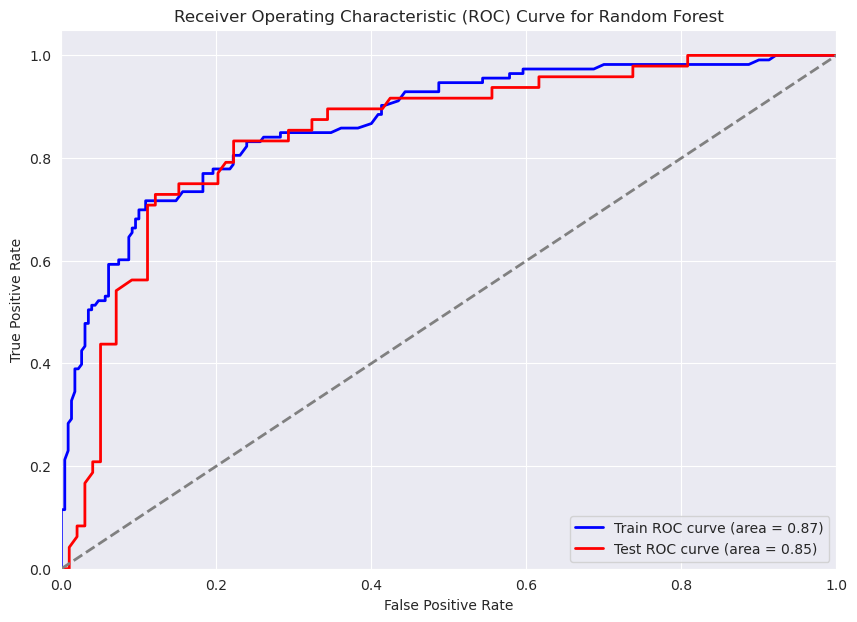

In [124]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=2,
    min_samples_split=6,
    min_samples_leaf=2,
    random_state=RANDOM_SEED,
    max_features=2
)

rf.fit(X_train_scaled, y_train)

clf_report(rf, X_test_scaled, y_test)

plot_ROC_AUC_curves(rf, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest")

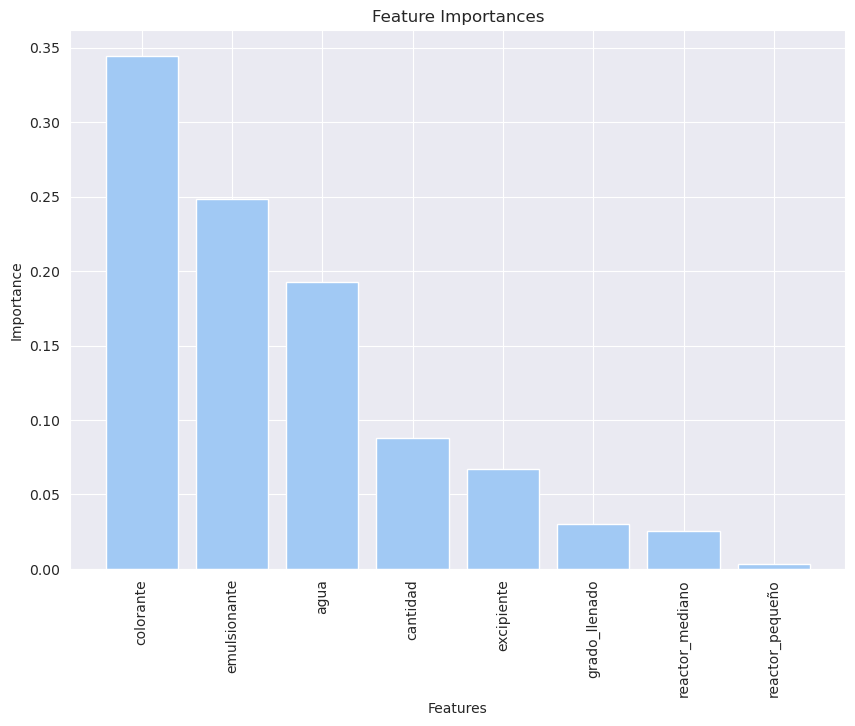

In [125]:
# Get the feature importances from the model
importances = rf.feature_importances_

# Get the indices of the features from the dataframe
indices = np.argsort(importances)[::-1]

# Get the names of the features from the dataframe
names = [X_train.columns[i] for i in indices]

# Create the plot
plt.figure(figsize=(10, 7))

# Add the feature importances to the plot
plt.bar(range(X_train.shape[1]), importances[indices])

# Add tick marks to the x-axis and rotate them
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Add axis labels and a title
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances');

plt.show()

Vamos a probar utilizando Stratifield K-Fold

In [138]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [139]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=2,
    min_samples_split=6,
    min_samples_leaf=2,
    random_state=RANDOM_SEED,
    max_features=2
)


In [140]:
roc_auc_scores = []

train_scores = []
validation_scores = []

train_scores = []

for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Entrena el modelo en el conjunto de entrenamiento del fold
    clf.fit(X_train_fold, y_train_fold)
    
    # Realiza predicciones en el conjunto de validación del fold
    y_pred_proba = clf.predict_proba(X_test_fold)[:, 1]
    
    # Calcula la métrica deseada (por ejemplo, ROC AUC) y guárdala
    fold_roc_auc = roc_auc_score(y_test_fold, y_pred_proba)
    roc_auc_scores.append(fold_roc_auc)

    # Evaluar el modelo en el conjunto de entrenamiento usando ROC AUC
    y_train_pred_proba = clf.predict_proba(X_train_fold)[:, 1]
    train_score = roc_auc_score(y_train_fold, y_train_pred_proba)
    train_scores.append(train_score)
        
    # Evaluar el modelo en el conjunto de validación usando ROC AUC
    y_val_pred_proba = clf.predict_proba(X_train_fold)[:, 1]
    val_score = roc_auc_score(y_train_fold, y_val_pred_proba)
    validation_scores.append(val_score)

In [141]:
average_roc_auc = np.mean(roc_auc_scores)
std_roc_auc = np.std(roc_auc_scores)


average_train_score = np.mean(train_scores)
std_train_score = np.std(train_scores)

average_val_score = np.mean(validation_scores)
std_val_score = np.std(validation_scores)

In [142]:
print(f"ROC AUC scores: {roc_auc_scores}")
print(f"Average ROC AUC: {average_roc_auc:.3f}")
print(f"Standard deviation of ROC AUC: {std_roc_auc:.3f}")

print(f"Train scores: {train_scores}")
print(f"Average train score: {average_train_score:.3f}")
print(f"Standard deviation of train score: {std_train_score:.3f}")


ROC AUC scores: [0.7463235294117648, 0.7982954545454546, 0.8948863636363635, 0.8465909090909091, 0.7765151515151516, 0.8712121212121212, 0.884469696969697, 0.8011363636363636, 0.9583333333333334, 0.8295454545454545]
Average ROC AUC: 0.841
Standard deviation of ROC AUC: 0.060
Train scores: [0.8712004302282079, 0.8726700838769803, 0.861078751164958, 0.8664958061509784, 0.8722506989748369, 0.863921248835042, 0.8639095992544268, 0.868697576887232, 0.8540191053122088, 0.8688606710158434]
Average train score: 0.866
Standard deviation of train score: 0.005


#### XGBoost

In [143]:
import xgboost as xgb

In [145]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state=RANDOM_SEED)

In [146]:
# Definir la cuadrícula de hiperparámetros
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'lambda': [1, 1.5],
    'alpha': [0, 0.5]
}

grid_search_xgb = GridSearchCV(xgb_clf, param_grid_xgb, cv=skf, scoring='roc_auc', n_jobs=-1, verbose=1)

# Ajustar el modelo
grid_search_xgb.fit(X, y)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=12, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_ty...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=12, ...),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.5], 'colsample_bytree': [0.8, 1.0],
                         'gamma': [0, 0.1, 0.2], 'lambda': [1, 1.5],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7, 10],
                         'min_child_weight': [1, 3, 5],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [147]:
grid_search_xgb.best_params_

{'alpha': 0.5,
 'colsample_bytree': 1.0,
 'gamma': 0.1,
 'lambda': 1.5,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 3,
 'subsample': 0.8}

In [1]:
# Creamos un modelo con los mejores hiperparámetros encontrados
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_SEED,
    alpha=0.5,
    colsample_bytree=1.0,
    gamma=0.1,
    lambda_=1.5,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=3,
    subsample=0.8
)

xgb_clf.fit(X_train_scaled, y_train)

clf_report(xgb_clf, X_test_scaled, y_test)

plot_ROC_AUC_curves(xgb_clf, X_train_scaled, y_train, X_test_scaled, y_test, "XGBoost")






NameError: name 'xgb' is not defined